Training Fixed λ=1:  42%|████▏     | 4192/10000 [00:03<00:04, 1306.59it/s, loss=6.249676e-03]

Learning rate updated to 0.001


Training Fixed λ=1:  82%|████████▏ | 8166/10000 [00:06<00:01, 1294.84it/s, loss=7.428798e-04]

Learning rate updated to 0.0001


Training Fixed λ=10:  42%|████▏     | 4242/10000 [00:03<00:04, 1355.88it/s, loss=2.046501e-01]

Learning rate updated to 0.001


Training Fixed λ=10:  82%|████████▏ | 8198/10000 [00:06<00:01, 1320.03it/s, loss=2.644984e-02]

Learning rate updated to 0.0001


Training Adaptive λ (λ=-1.15):  41%|████      | 4075/10000 [00:05<00:08, 732.11it/s, loss=9.920695e-02]

Learning rate updated to 0.001


Training Adaptive λ (λ=-1.04):  81%|████████  | 8075/10000 [00:11<00:02, 733.27it/s, loss=1.511815e-01]

Learning rate updated to 0.0001


Training Adaptive λ (λ=-1.03): 100%|██████████| 10000/10000 [00:13<00:00, 741.13it/s, loss=6.597558e-02]


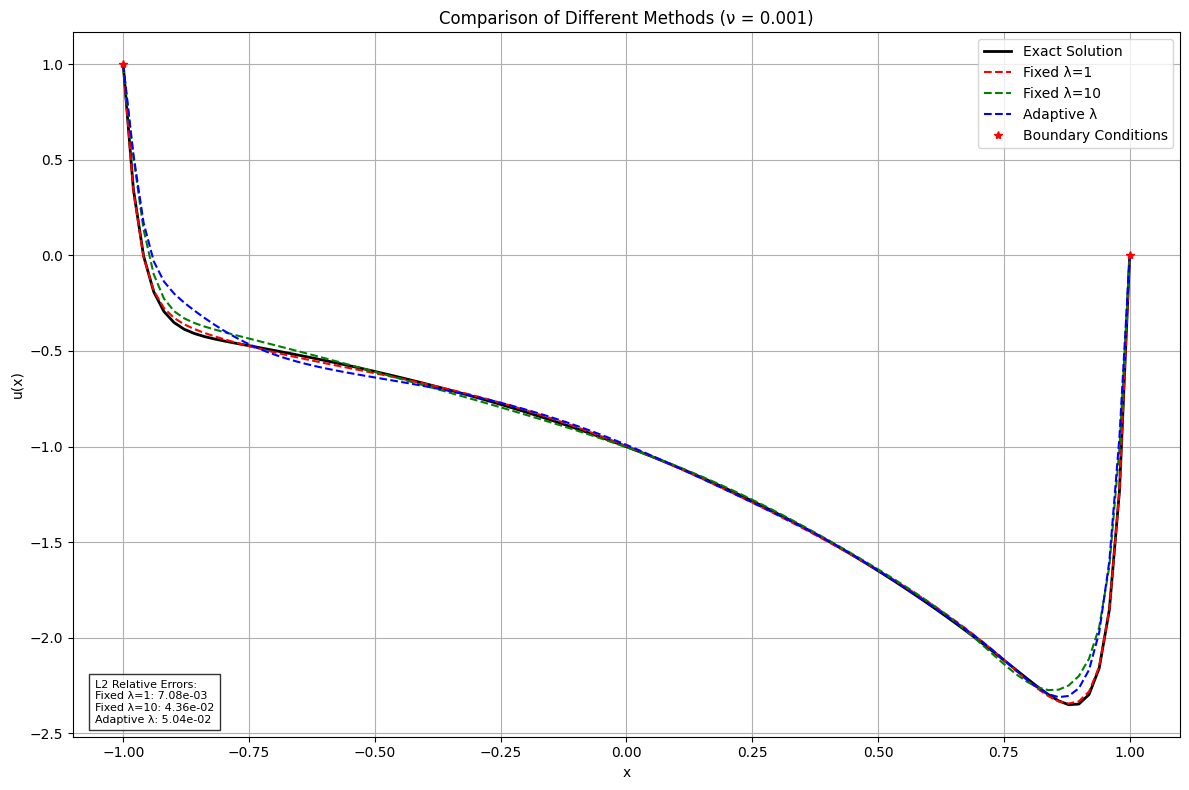

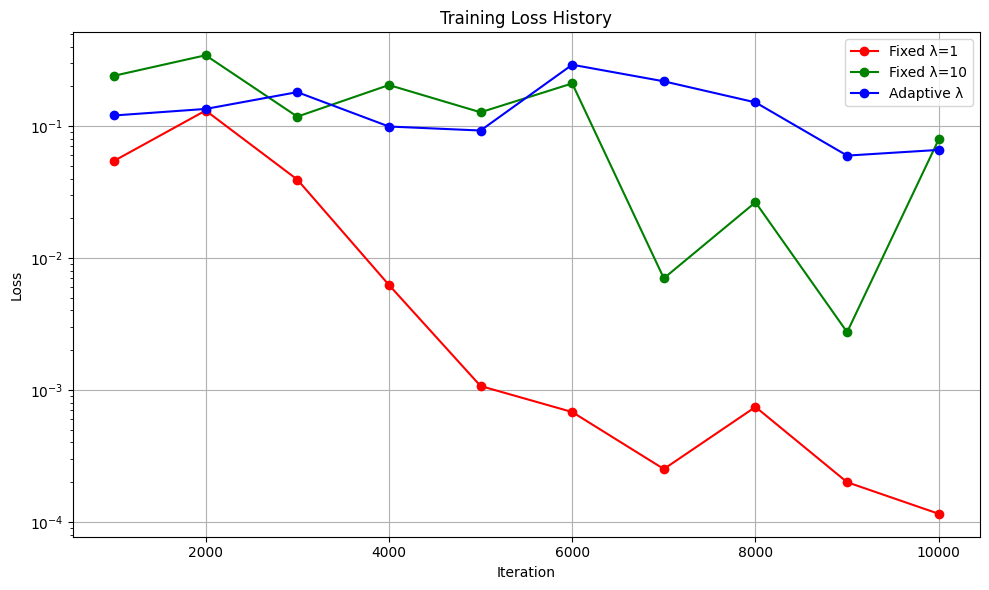


Final L2 relative errors:
Fixed λ=1: 7.081931e-03
Fixed λ=10: 4.364151e-02
Adaptive λ: 5.040396e-02


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict
from tqdm import tqdm

@dataclass
class ModelConfig:
    """Configuration for the neural network model."""
    input_dim: int
    hidden_layers: List[int]
    output_dim: int
    activation: nn.Module = nn.Tanh()
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

@dataclass
class TrainingConfig:
    """Configuration for the training process."""
    epochs: int = 10000
    batch_size: int = 32
    initial_lr: float = 0.01
    lr_decay_factor: float = 0.1
    lr_decay_epochs: int = 4000
    lambda_init: float = -4.6
    adaptive_lambda: bool = False
    adaptive_rate: float = 0.01

class PINN(nn.Module):
    """Physics-Informed Neural Network for solving differential equations."""
    
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.layers = self._build_layers(config)
        self.activation = config.activation
        self.device = config.device
        
    def _build_layers(self, config: ModelConfig) -> nn.ModuleList:
        """Construct neural network layers with Xavier initialization."""
        layer_sizes = [config.input_dim] + config.hidden_layers + [config.output_dim]
        layers = nn.ModuleList()
        
        for i in range(len(layer_sizes) - 1):
            layer = nn.Linear(layer_sizes[i], layer_sizes[i + 1])
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
            layers.append(layer)
            
        return layers
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network."""
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        return self.layers[-1](x)

class DiffEqSolver:
    """Solver for differential equations using PINN."""
    
    def __init__(self, model_config: ModelConfig, training_config: TrainingConfig):
        self.model = PINN(model_config).to(model_config.device)
        self.config = training_config
        self.device = model_config.device
        self.nu = 0.001  # Diffusion coefficient
        
    def _boundary_weight(self, lambda_val: float) -> float:
        """Calculate boundary condition weight."""
        return 100 / (1 + np.exp(-lambda_val))
    
    def _compute_pde_residual(self, x: torch.Tensor, u: torch.Tensor) -> torch.Tensor:
        """Compute the PDE residual."""
        du = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), 
                               create_graph=True)[0]
        d2u = torch.autograd.grad(du, x, grad_outputs=torch.ones_like(du), 
                                create_graph=True)[0]
        return self.nu * d2u - u - torch.exp(x)
    
    def _compute_loss(self, x: torch.Tensor, lambda_val: float) -> Tuple[torch.Tensor, float]:
        """Compute total loss including PDE and boundary conditions."""
        u = self.model(x)
        pde_residual = self._compute_pde_residual(x, u)
        loss = torch.mean(pde_residual**2)
        
        boundary_weight = self._boundary_weight(lambda_val)
        left = torch.tensor([-1.]).reshape(1, 1).to(self.device)
        right = torch.tensor([1.]).reshape(1, 1).to(self.device)
        
        bc_loss = torch.mean((self.model(left) - 1)**2 + (self.model(right) - 0)**2)
        loss += boundary_weight * bc_loss
        
        return loss, bc_loss.item()
    
    def train(self, desc: str = "Training") -> List[float]:
        """Train the model and return loss history."""
        optimizer = optim.Adam(self.model.parameters(), lr=self.config.initial_lr)
        lambda_val = self.config.lambda_init
        losses = []
        
        pbar = tqdm(range(1, self.config.epochs + 1), desc=desc)
        for epoch in pbar:
            x = (2 * torch.rand(self.config.batch_size, 1) - 1).to(self.device)
            x.requires_grad_(True)
            
            optimizer.zero_grad()
            loss, bc_loss = self._compute_loss(x, lambda_val)
            loss.backward()
            optimizer.step()
            
            if self.config.adaptive_lambda:
                lambda_val += (self.config.adaptive_rate * bc_loss * 100 * 
                             np.exp(-lambda_val) / (1 + np.exp(-lambda_val))**2)
                pbar.set_description(f'{desc} (λ={lambda_val:.2f})')
            
            if epoch % self.config.lr_decay_epochs == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= self.config.lr_decay_factor
                pbar.write(f'Learning rate updated to {param_group["lr"]}')
            
            if epoch % 1000 == 0:
                losses.append(loss.item())
                pbar.set_postfix({'loss': f'{loss.item():.6e}'})
        
        return losses

def exact_solution(x: np.ndarray) -> np.ndarray:
    """Compute the exact solution of the differential equation."""
    c1 = ((1 + 1000/np.exp(1)/999)*np.exp((-10*np.sqrt(10))) - 
          np.exp(10*np.sqrt(10))*1000*np.exp(1)/999) / (np.exp(-20*np.sqrt(10)) - 
          np.exp(20*np.sqrt(10)))
    c2 = (np.exp(-10*np.sqrt(10))*1000*np.exp(1)/999  - 
          np.exp(10*np.sqrt(10)) * (1+1000/np.exp(1)/999)) / (np.exp(-20*np.sqrt(10)) - 
          np.exp(20*np.sqrt(10)))
    return (c1*np.exp(10*np.sqrt(10)*x) + c2*np.exp(-10*np.sqrt(10)*x) - 
            (1000/999)*np.exp(x))

def plot_comparison(solvers: Dict[str, DiffEqSolver], x_plot: np.ndarray, 
                   y_exact: np.ndarray) -> Dict[str, float]:
    """Plot comparison of different methods and return their errors."""
    plt.figure(figsize=(12, 8))
    plt.plot(x_plot, y_exact, 'k-', label='Exact Solution', linewidth=2)
    
    colors = ['r--', 'g--', 'b--']
    errors = {}
    
    for (name, solver), color in zip(solvers.items(), colors):
        x_tensor = torch.tensor(x_plot.reshape(-1, 1), dtype=torch.float32).to(solver.device)
        with torch.no_grad():
            y_pred = solver.model(x_tensor).cpu().numpy()
        
        errors[name] = np.linalg.norm(y_exact - y_pred.flatten()) / np.linalg.norm(y_exact)
        plt.plot(x_plot, y_pred, color, label=name, linewidth=1.5)
    
    plt.plot([-1, 1], [1, 0], 'r*', label='Boundary Conditions')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Comparison of Different Methods (ν = 0.001)')
    plt.grid(True)
    plt.legend()
    
    # Add error text box
    error_text = '\n'.join([f'{name}: {error:.2e}' for name, error in errors.items()])
    plt.text(0.02, 0.02, f'L2 Relative Errors:\n{error_text}',
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8), 
             fontsize=8)
    
    plt.tight_layout()
    return errors

def plot_losses(all_losses: Dict[str, List[float]]):
    """Plot training loss history for all methods."""
    plt.figure(figsize=(10, 6))
    colors = ['r-o', 'g-o', 'b-o']
    
    for (name, losses), color in zip(all_losses.items(), colors):
        plt.semilogy(range(1000, len(losses) * 1000 + 1, 1000), 
                    losses, color, label=name)
    
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss History')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

def main():
    # Set random seeds
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Base configurations
    model_config = ModelConfig(
        input_dim=1,
        hidden_layers=[16, 16, 16],
        output_dim=1
    )
    
    # Create solvers with different lambda strategies
    solvers = {}
    training_configs = {
        'Fixed λ=1': TrainingConfig(lambda_init=-4.6, adaptive_lambda=False),
        'Fixed λ=10': TrainingConfig(lambda_init=-2.2, adaptive_lambda=False),
        'Adaptive λ': TrainingConfig(lambda_init=-4.6, adaptive_lambda=True)
    }
    
    # Train all models
    all_losses = {}
    for name, config in training_configs.items():
        solver = DiffEqSolver(model_config, config)
        losses = solver.train(desc=f'Training {name}')
        solvers[name] = solver
        all_losses[name] = losses
    
    # Generate comparison data
    x_plot = np.linspace(-1, 1, 100)
    y_exact = exact_solution(x_plot)
    
    # Plot comparisons
    errors = plot_comparison(solvers, x_plot, y_exact)
    plt.show()
    
    # Plot loss histories
    plot_losses(all_losses)
    plt.show()
    
    # Print final errors
    print('\nFinal L2 relative errors:')
    for name, error in errors.items():
        print(f'{name}: {error:.6e}')

if __name__ == "__main__":
    main()